In [25]:
import numpy as np
import pandas as pd

import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [26]:
main_dir = "/kaggle/input/utkface-new/UTKFace"

In [27]:
path_arr = []
age_arr = []

for file in tqdm(os.listdir(main_dir)):
    labels = file.split("_")
    
    filepath = os.path.join(main_dir, file)
    age = int(labels[0])
    
    path_arr.append(filepath)
    age_arr.append(age)

100%|██████████| 23708/23708 [00:00<00:00, 270450.12it/s]


In [28]:
df = pd.DataFrame({
    "image_path": path_arr,
    "age": age_arr,
})

In [29]:
df.head(10)

,image_path,age
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17
5,/kaggle/input/utkface-new/UTKFace/44_0_3_20170...,44
6,/kaggle/input/utkface-new/UTKFace/35_0_2_20170...,35
7,/kaggle/input/utkface-new/UTKFace/76_0_0_20170...,76
8,/kaggle/input/utkface-new/UTKFace/36_1_0_20170...,36
9,/kaggle/input/utkface-new/UTKFace/34_0_3_20170...,34


In [30]:
TRAIN, VALID, TEST = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

TRAIN = TRAIN.reset_index(drop=True)
VALID = VALID.reset_index(drop=True)
TEST = TEST.reset_index(drop=True)

print("Total shape:", df.shape[0])
print("Shape of trainset:", TRAIN.shape[0])
print("Shape of Validation set:", VALID.shape[0])
print("Shape of testset:", TEST.shape[0])

Total shape: 23708
Shape of trainset: 14224
Shape of Validation set: 4742
Shape of testset: 4742


## Data Visualization

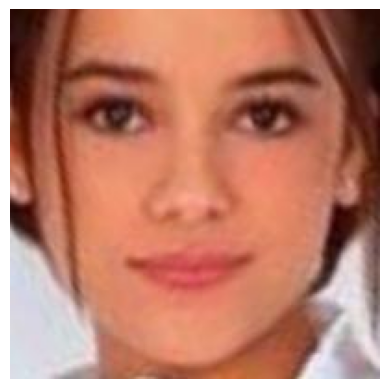

In [31]:
from PIL import Image
img=Image.open(df['image_path'][10])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

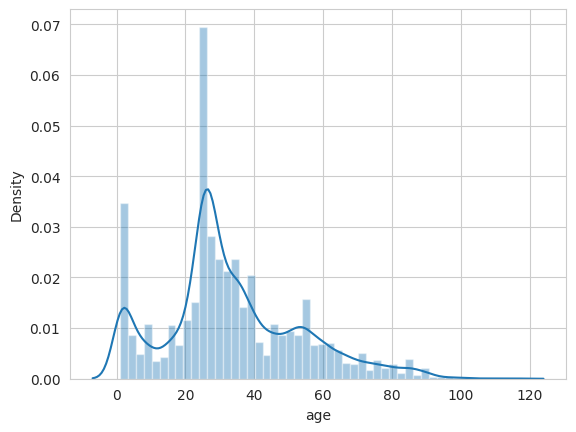

In [32]:
sns.distplot(df['age'])

In [33]:
train_img_arr = []
train_age_arr = []

for idx, row in tqdm(TRAIN.iterrows()):
    img = load_img(row['image_path'], color_mode="grayscale")
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img, dtype=float)
    img /= 255.0
    train_img_arr.append(img)
    train_age_arr.append(row['age'])
    
train_img_arr = np.array(train_img_arr).reshape(len(train_img_arr), 128, 128, 1)
train_age_arr = np.array(train_age_arr)

14224it [00:24, 571.39it/s]


In [34]:
valid_img_arr = []
valid_gender_arr = []
valid_age_arr = []

for idx, row in tqdm(VALID.iterrows()):
    img = load_img(row['image_path'], color_mode="grayscale")
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img, dtype=float)
    img /= 255.0
    valid_img_arr.append(img)
    valid_age_arr.append(row['age'])
    
valid_img_arr = np.array(valid_img_arr).reshape(len(valid_img_arr), 128, 128, 1)
valid_age_arr = np.array(valid_age_arr)

4742it [00:08, 567.65it/s]


In [35]:
test_img_arr = []
test_gender_arr = []
test_age_arr = []

for idx, row in tqdm(TEST.iterrows()):
    img = load_img(row['image_path'], color_mode="grayscale")
    img = img.resize((128, 128), Image.LANCZOS)
    img = np.array(img, dtype=float)
    img /= 255.0
    test_img_arr.append(img)
    test_age_arr.append(row['age'])
    
test_img_arr = np.array(test_img_arr).reshape(len(test_img_arr), 128, 128, 1)
test_age_arr = np.array(test_age_arr)

4742it [00:08, 588.03it/s]


## Model Initiation

In [36]:
inputs = Input(shape=(128, 128, 1))

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max1)
max2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max2)
max3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max3)
max4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, kernel_size=(3, 3), activation='relu')(max4)
max5 = MaxPooling2D(pool_size=(2, 2))(conv5)


flat = Flatten()(max5)

dense1 = Dense(256, activation='relu')(flat)
drop1 = Dropout(0.3)(dense1)
output_age = Dense(1, activation='relu')(drop1)

model = Model(inputs=[inputs], outputs=[output_age])

model.compile(loss='mae',
              optimizer='adam',
              metrics=['mae'])

In [37]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,092,801 (7.98 MB)

 Trainable params: 2,092,801 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

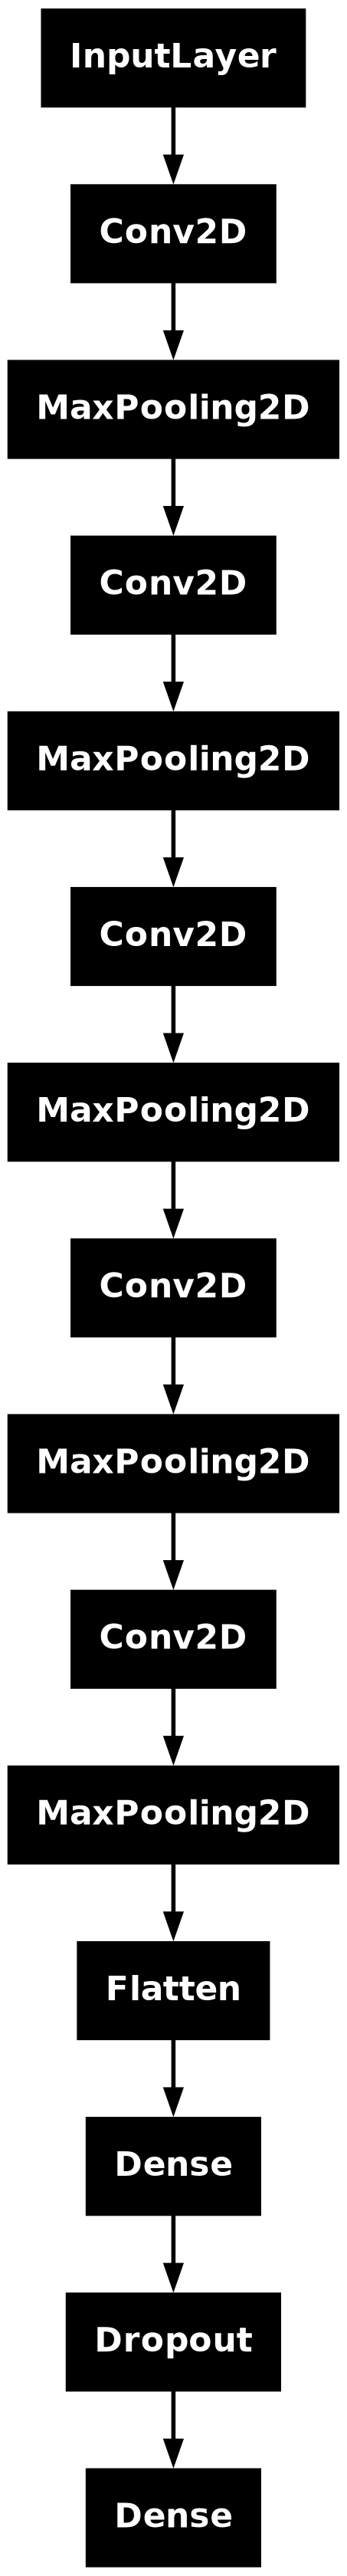

In [38]:
plot_model(model)

In [39]:
history = model.fit(x=train_img_arr, y=[train_age_arr], batch_size=64, epochs=25, validation_data=(valid_img_arr, [valid_age_arr]))

Epoch 1/25


2024-06-28 07:58:58.282230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.20425, expected 2.23983
2024-06-28 07:58:58.282288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.80002, expected 1.8356
2024-06-28 07:58:58.282298: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.12776, expected 2.16334
2024-06-28 07:58:58.282305: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.34052, expected 2.3761
2024-06-28 07:58:58.282313: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.80511, expected 1.84069
2024-06-28 07:58:58.282321: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.6141, expected 1.64968
2024-06-28 07:58:58.282329: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.86052, expected 1.8961
2024-06-28 07:58:58.282336: E external/local_xla/xla/servic

 10/223 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 27.6771 - mae: 27.6771

I0000 00:00:1719561544.135174     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719561544.156651     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/223 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 17.7090 - mae: 17.7090

2024-06-28 07:59:08.858238: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47628: 4.20935, expected 3.49544
2024-06-28 07:59:08.858305: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47629: 3.48288, expected 2.76897
2024-06-28 07:59:08.858315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47630: 3.97554, expected 3.26164
2024-06-28 07:59:08.858322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47631: 3.65741, expected 2.9435
2024-06-28 07:59:08.858330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47632: 3.23787, expected 2.52397
2024-06-28 07:59:08.858338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47633: 3.11375, expected 2.39984
2024-06-28 07:59:08.858345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47634: 2.68378, expected 1.96988
2024-06-28 07:59:08.858353: 

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 17.6884 - mae: 17.6884

W0000 00:00:1719561556.254712     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-28 07:59:16.776913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31752: 2.5113, expected 1.88489
2024-06-28 07:59:16.776969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31753: 2.58354, expected 1.95712
2024-06-28 07:59:16.776978: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31754: 2.90737, expected 2.28095
2024-06-28 07:59:16.776986: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31755: 2.50974, expected 1.88333
2024-06-28 07:59:16.776994: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31756: 2.3616, expected 1.73519
2024-06-28 07:59:16.777002: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31757: 2.47808, expected 1.85167
2024-06-28 07:59:16.777010: E external/loca

223/223 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 17.6817 - mae: 17.6817 - val_loss: 15.9036 - val_mae: 15.9036
Epoch 2/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 14.7481 - mae: 14.7481 - val_loss: 13.8448 - val_mae: 13.8448
Epoch 3/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 14.0530 - mae: 14.0530 - val_loss: 11.5780 - val_mae: 11.5780
Epoch 4/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 10.9880 - mae: 10.9880 - val_loss: 11.2115 - val_mae: 11.2115
Epoch 5/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 9.8193 - mae: 9.8193 - val_loss: 8.8122 - val_mae: 8.8122
Epoch 6/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 8.6690 - mae: 8.6690 - val_loss: 8.3195 - val_mae: 8.3195
Epoch 7/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 8.5783 - mae: 8.5783 - val_loss: 7.8910 - val_mae: 7.8910
Epoch 8/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 7.8944 - mae: 7.8944 - val_loss: 7.9524 - val_mae: 7.9524
Epoch 9/25
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s

In [40]:
# history = model.fit(x=train_img_arr, y=[train_age_arr], 
#                     epochs=10, 
#                     batch_size=32, 
#                     validation_data=(valid_img_arr, [valid_age_arr]), 
#                     verbose=1)

## Plotting Results

In [41]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mae,val_loss,val_mae
0,16.177406,16.177406,15.903563,15.903563
1,14.791573,14.791573,13.844776,13.844776
2,13.225905,13.225905,11.578014,11.578014
3,10.405874,10.405874,11.211490,11.211490
4,9.424603,9.424603,8.812231,8.812231


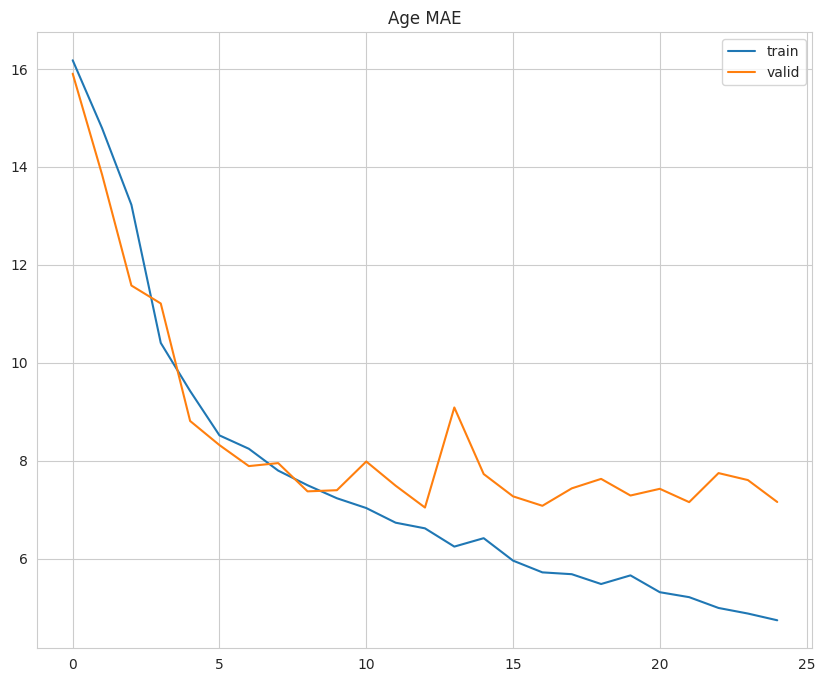

In [42]:
if "mae" in history_df.columns and "val_mae" in history_df.columns:
    plt.figure(figsize=(10, 8))
    plt.title("Age MAE")
    plt.plot(history_df["mae"])
    plt.plot(history_df["val_mae"])
    plt.legend(["train", "valid"])
    plt.show()
else:
    print("Error: Columns 'mae' and/or 'val_mae' do not exist in the DataFrame.")

## Model's performance on Testset

In [43]:
preds = model.predict(test_img_arr, verbose=0)
pred_age = np.round(preds).flatten().tolist()

2024-06-28 08:01:06.281892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.39151, expected 2.7295
2024-06-28 08:01:06.281962: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.36773, expected 2.70572
2024-06-28 08:01:06.281976: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.08268, expected 2.42067
2024-06-28 08:01:06.281988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.1679, expected 2.50589
2024-06-28 08:01:06.282001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.96544, expected 2.30343
2024-06-28 08:01:06.282019: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.78427, expected 2.12226
2024-06-28 08:01:06.282036: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.73395, expected 2.07194
2024-06-28 08:01:06.282048: E external/local_xla/xla/serv

In [44]:
TEST["pred_age"] = pred_age

In [45]:
TEST.head()

,image_path,age,pred_age
0,/kaggle/input/utkface-new/UTKFace/28_0_1_20170...,28,33.0
1,/kaggle/input/utkface-new/UTKFace/51_0_0_20170...,51,56.0
2,/kaggle/input/utkface-new/UTKFace/36_0_1_20170...,36,24.0
3,/kaggle/input/utkface-new/UTKFace/25_0_1_20170...,25,25.0
4,/kaggle/input/utkface-new/UTKFace/28_1_0_20170...,28,25.0


In [46]:
def visualize_age_results(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            img_age = df.loc[a][['age']].values[0]
            img_pred_age = df.loc[a][['pred_age']].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"Pred Age: {img_pred_age}(True:{img_age})")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

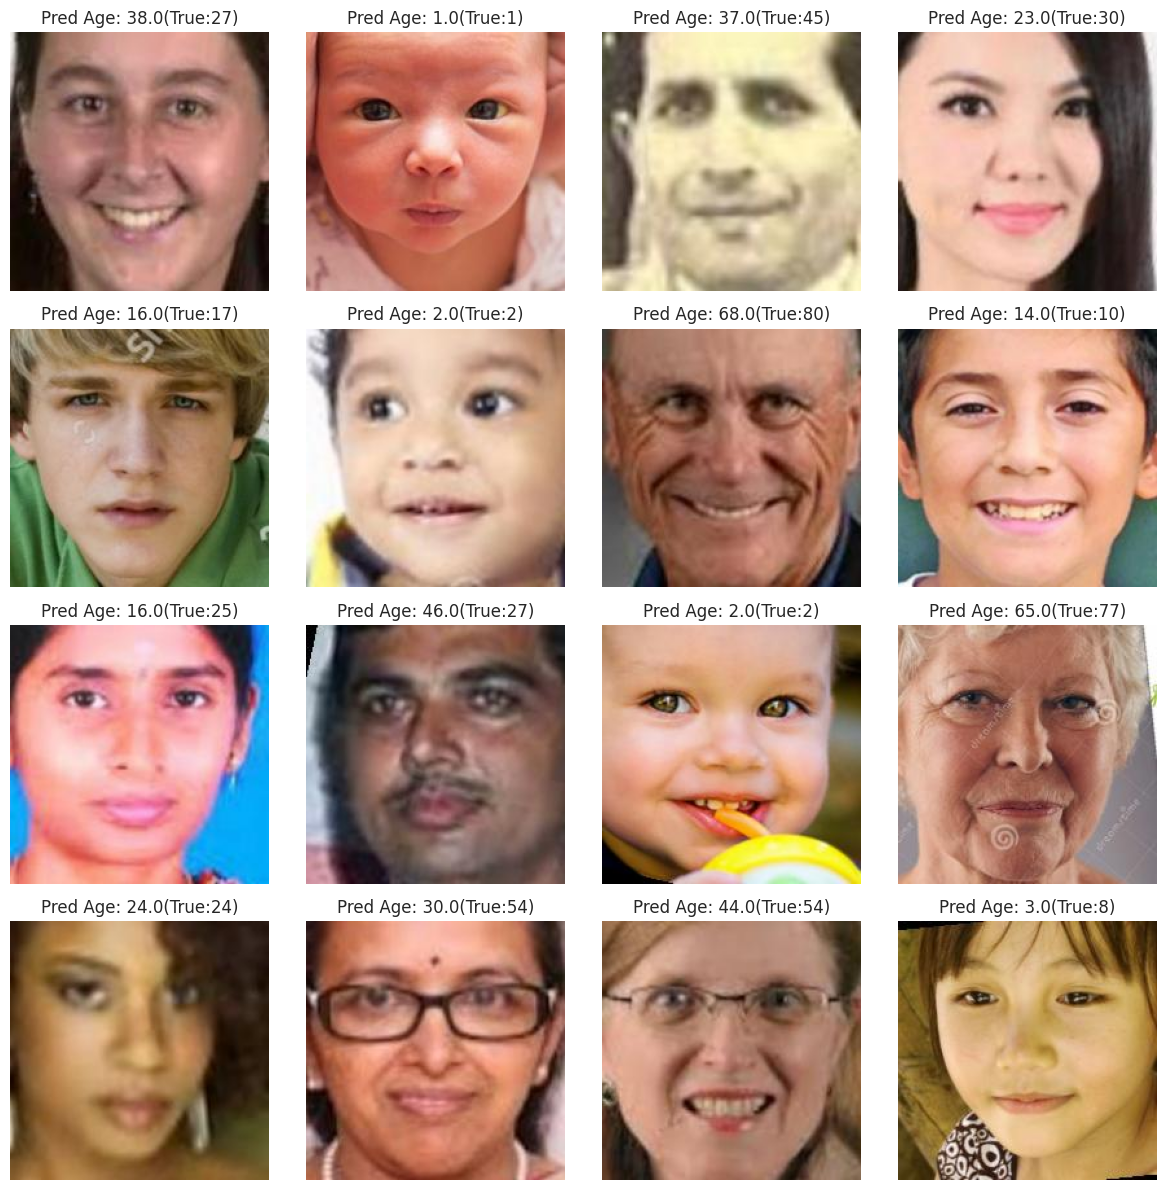

In [47]:
visualize_age_results(TEST)

In [49]:
import tensorflow as tf

model.save('Age_Detection_Model_v1.1.h5')